# Calculos en vecindades I

En este taller vamos a utilizar Python para calcular un par de variables, asociadas a cada polígono del espacio, en función de las propiedades de los polígonos vecinos.

Si pensamos en términos de _rasters_ el ejercicio es relatívamente simple ya que la función de vecindad está _implícita_ en la estructura de los datos, por ejemplo, si tenemos el elemento  $(i,j)$ de una matriz, entonces su vecindad de torre $V_{t}(i,j)$ está dada por:

$$V_{t}(i,j) = [(i-1,j), (i+1,j), (i,j+1), (i,j-1)]$$

De foma análoga es posible encontrar la vecindad de reina de cada elemento de la matriz.

Ahora, en el caso de coberturas (en este contexto coberturas quiere decir que los polígonos cubren totalmente el espacio de estudio), con polígonos arbitrarios la cuestión es más compleja: no tenemos un índice que defina de forma implícita las relaciones de vecindad, tenemos que encontrar a los vecinos de cada polígono a partir de operaciones geométricas. Una de las ventajas de usar Python es que, al ser muy usado por la comunidad científica en general, existen muchas librerías que nos pueden ayudar a resolver nuestros problemas, en este caso [pysal](http://pysal.readthedocs.io/en/latest/index.html) provee una manera fácil de acceder a los polígonos vecinos.

El taller está organizado de la siguiente forma:

1. Leer los datos de dos fuentes diferentes y procesarlos para calcular las variables que nos interesan
2. Encontrar los vecinos de cada polígono
3. Calcular un par de variables en función de una vecindad de primer orden
4. Representar el resultado que obtengamos

## 1. Leyendo y transformando los datos

Lo que vamos a calcular al final del taller  son dos variables que representan la mezcla de susos de suelo y la intensidad de las actividades en una ciudad, estas son dos variables muy usdas en estudios urbanos para, por ejemplo, modelar el uso del automóvil como función de los entornos urbanos locales.

Para calcular estas variables, lo primero que necesitamos es obtener un conteo de los diferentes tipos de actividades urbanas que ocurren en una zona determinada. Para esto, vamos a utilizar la base de datos del [DENUE](http://www.beta.inegi.org.mx/app/mapa/denue/) publicada por el INEGI. Duarante el taller trabajaremos con datos para la Ciudad de México, sin embargo, para la tarea ustedes trabajarán con una zona metropolitana de su elección. Para agregar los datos usaremos las Áreas Geoestadísticas Básicas (AGEBS) del INEGI.

Entonces, el primer paso es leer los datos del DENUE, para eso vamos a utilizar la librería [GeoPandas](http://geopandas.org/) que nos provee una estructura de datos similar a los DataFrames de R y que, además, soporta objetos geográficos.

Para facilitar el trabajo, descompriman los archivos en el directorio `datos`de este repositorio.

Entonces, para leer los datos, lo primero que necesitamos hacer es importar la librería GeoPandas y después crear un GeoDataFrame a parti del shapefile con los datos:

In [71]:
import geopandas as gpd

denue = gpd.read_file("datos/DENUE_INEGI_09_.shp")
denue.head()

,ageb,cod_postal,codigo_act,correoelec,cve_ent,cve_loc,cve_mun,edificio,edificio_e,entidad,...,raz_social,telefono,tipoCenCom,tipoUniEco,tipo_asent,tipo_v_e_1,tipo_v_e_2,tipo_v_e_3,tipo_vial,www
0,1498,06880,315229,,09,0001,015,,,DISTRITO FEDERAL,...,CONFECCIONES CLABECK SA DE CV,,,Fijo,COLONIA,VIADUCTO,CALLE,CALLE,CALLE,
1,0800,11650,311812,,09,0001,016,,,DISTRITO FEDERAL,...,"LA PANERA, S.A. DE C.V.",5555400347,,Fijo,COLONIA,CALLE,CALLE,CALLE,CALLE,
2,0090,10010,222111,,09,0001,008,,,DISTRITO FEDERAL,...,SISTEMA DE AGUAS DE LA CIUDAD DE MÉXICO,,,Fijo,COLONIA,CALLE,AVENIDA,CALLE,PROLONGACIÓN,
3,0115,03400,311520,,09,0001,014,,,DISTRITO FEDERAL,...,,5555198254,,Fijo,COLONIA,CALLE,CALLE,CALLE,CALLE,
4,0130,04000,316991,,09,0001,003,,PLANTA BAJA,DISTRITO FEDERAL,...,,,MERCADO PÚBLICO,Semifijo,COLONIA,ANDADOR,CALLE,CALLE,CALLE,


Como pueden ver, el archivo tiene 42 columnas, las que nos interesan en este momento son las que describen la actividad de cada unidad:

(Noten como para pedir las columnas que queremos, símplemente pasamos la lista de nombres al operador de selección [ ])

In [73]:
denue[["codigo_act", "nom_estab"]].head()

,codigo_act,nom_estab
0,315229,CONFECCIONES CLABECK SA DE CV
1,311812,LA PANERA
2,222111,TANQUE Y REBOMBEO DE AGUA CERRO DEL JUDÍO
3,311520,PALETERÍA LA MICHOACANA
4,316991,"FABRICACIÓN DE BOLSOS DE MANO, MALETAS Y SIMIL..."


El código de la actividad corresponde a la clasificación del [SCIAN](http://www3.inegi.org.mx/sistemas/SCIAN/scian.aspx) y sirve para clasificar las actividades económicas. Para este taller, vamos a agregar diferentes actividades económicas en tres grupos de usos de suelo:

* Comercio: actividades que se dedican a la venta al menudeo
* Oficinas: lugares en los que se trabaja en una oficina
* Ocio: sitios de esparcimiento. Bares, teatros, etcétera

Cada uno de estos usos es una agregación de diferentes actividades del SCIAN, para este taller vamos a considerar las siguientes agregaciones:

* Comercio: empiezan con 461, 462, 463, 464, 465 o 466
* Oficinas: empiezan con 51, 521, 523, 524, 5312, 5313, 541 o 55
* Ocio: empiezan con 711121, 71212, 7132, 7139, 7211, 7224 o 7225

Para etiquetar cada renglón en la base de datos con el uso al que pertenece vamos a usar el método [apply](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.apply.html#pandas.Series.apply) de GeoPandas (en relidad es un método de la librería [Pandas](http://pandas.pydata.org/) que es _heredado_ por su extensión espacial).

Lo que hace `apply` es aplicar una función a cada elemento de una _Serie_. Una Serie es una columna de un DataFrame. Para entender cómo funciona, vamos a revisar el ejemplo de la documentación: 

In [5]:
import pandas as pd
import numpy as np
df = pd.DataFrame(np.random.randn(3, 3))
df

,0,1,2
0,-1.820843,1.926272,0.626165
1,1.243174,-0.371031,-1.292078
2,0.326875,0.338903,0.910319


Lo primero que hicimos fue importar dos librerías: Pandas y Numpy (en este caso numpy sólo la vamos a utilizar para generar un arreglo de números aleatorios) y después construir un DataFrame con 3 renglones y 3 columnas.

Ahora vamos a aplicar una función a cada elemento de la primera columna del DataFrame:

In [6]:
def square(x):
    return x**2

df[[0]].apply(square)

,0
0,3.315469
1,1.545481
2,0.106847


Como pueden ver, el resultado es una serie (una columna) con el resultado de aplicar nuestra función a cada renglón de la serie 0. Esta nueva columna la podemos agregar fácilmente a nuestros datos originales: 

In [7]:
df['squared'] = df[[0]].apply(square)
df

,0,1,2,squared
0,-1.820843,1.926272,0.626165,3.315469
1,1.243174,-0.371031,-1.292078,1.545481
2,0.326875,0.338903,0.910319,0.106847


**Ejercicio rápido:** repite lo que acabamos de hacer pero con una función que calcule la mitad de cada elemento

Ahora sí podemos regresar a nuestros propios datos. Lo primero que tenemos que hacer es escribir una función que, a partir del código del SCIAN, nos regrese nuestra propia clasificación:

In [75]:
def clasifica(codigo):
    comercio = ['461', '462', '463', '464', '465', '466']
    oficinas = ['51', '521', '523', '524', '5312', '5313', '541', '55']
    ocio = ['711121', '71212', '7132', '7139', '7211', '7224', '7225']
    usos = {'comercio': comercio, 'oficinas':oficinas, 'ocio': ocio}
    for actividad, claves in usos.items():
        for c in claves:
            if str(codigo).startswith(c):
                return actividad
            

La función parece bastante complicada, pero si lo pensamos con clama en realidad es bastante sencilla:

* Primero hacemos una lista con los _caractéres_ que definen cada actividad
* Luego hacemos un diccionario que relaciona el nombre de la actividad con lla listya de caractéres que la definen
* Iteramos sobre el diccionario, es decir, para cada elemento del diccionario obtenemos el par llave:valor
* Como en este caso el valor es una lista, entonces para cada elemento de las lista de caractéres buscamos si el código de la actividad empieza con los caractéres que nos interesan y si es cierto, regresamos el nombre de la actividad

Apliquemos ahora la función a nuestros datos:

In [76]:
clases = denue['codigo_act'].apply(clasifica)
denue['clase'] = clases
denue[['codigo_act', 'clase']][denue['clase']== 'oficinas'].head()

,codigo_act,clase
260002,512113,oficinas
260006,512111,oficinas
260008,517910,oficinas
260010,531210,oficinas
260012,531210,oficinas


**Ejercicio rápido:** Verifica las demás clases de actividades

Ahora, si se dan cuenta, la clasificación que hicimos no regresa valores para todas la filas. Es decir, no todas las actividades del DENUE corresponden a alguna de nuestras categorías: 

In [78]:
denue.loc[denue['clase'].isnull()].head()

,ageb,cod_postal,codigo_act,correoelec,cve_ent,cve_loc,cve_mun,edificio,edificio_e,entidad,...,telefono,tipoCenCom,tipoUniEco,tipo_asent,tipo_v_e_1,tipo_v_e_2,tipo_v_e_3,tipo_vial,www,clase
0,1498,06880,315229,,09,0001,015,,,DISTRITO FEDERAL,...,,,Fijo,COLONIA,VIADUCTO,CALLE,CALLE,CALLE,,None
1,0800,11650,311812,,09,0001,016,,,DISTRITO FEDERAL,...,5555400347,,Fijo,COLONIA,CALLE,CALLE,CALLE,CALLE,,None
2,0090,10010,222111,,09,0001,008,,,DISTRITO FEDERAL,...,,,Fijo,COLONIA,CALLE,AVENIDA,CALLE,PROLONGACIÓN,,None
3,0115,03400,311520,,09,0001,014,,,DISTRITO FEDERAL,...,5555198254,,Fijo,COLONIA,CALLE,CALLE,CALLE,CALLE,,None
4,0130,04000,316991,,09,0001,003,,PLANTA BAJA,DISTRITO FEDERAL,...,,MERCADO PÚBLICO,Semifijo,COLONIA,ANDADOR,CALLE,CALLE,CALLE,,None


Fíjense como estamos usando aquí `loc` para seleccionar filas que cumplan con una condición. Pandas tiene varias formas de seleccionar (ya hemos usado por lo menos dos aquí).  [Aquí](https://pandas.pydata.org/pandas-docs/stable/indexing.html) puedes ver la documentación oficial de los métodos para seleccionar filas en Pandas, en esta otra [liga](https://chrisalbon.com/python/pandas_indexing_selecting.html) hay algunos ejemplos extra

Filtremos entonces las filas que no corresponden a alguna de nuestras clases:

In [79]:
denue = denue.loc[denue['clase'].notnull()]
denue.head()

,ageb,cod_postal,codigo_act,correoelec,cve_ent,cve_loc,cve_mun,edificio,edificio_e,entidad,...,telefono,tipoCenCom,tipoUniEco,tipo_asent,tipo_v_e_1,tipo_v_e_2,tipo_v_e_3,tipo_vial,www,clase
50000,1355,04800,461110,,09,0001,003,,,DISTRITO FEDERAL,...,,,Fijo,UNIDAD HABITACIONAL,ANDADOR,ANDADOR,,ANDADOR,,comercio
50001,1970,07910,461110,,09,0001,005,,,DISTRITO FEDERAL,...,,,Fijo,COLONIA,AVENIDA,AVENIDA,AVENIDA,AVENIDA,,comercio
50002,0101,07160,461110,,09,0001,005,,,DISTRITO FEDERAL,...,,,Fijo,COLONIA,CALLE,CALLE,CALLE,CALLE,,comercio
50004,2460,09410,461110,,09,0001,007,,,DISTRITO FEDERAL,...,,,Fijo,COLONIA,AVENIDA,CIRCUITO,AVENIDA,AVENIDA,,comercio
50005,0378,13020,461110,,09,0001,011,,,DISTRITO FEDERAL,...,,,Fijo,COLONIA,CALLE,AVENIDA,CALLE,AVENIDA,,comercio


**Ejercicio rápido:** Comprueba que, en efecto, `denue` ya no contenga valores nulos en la columna clase

Recapitulemos un momento. Hasta aquí tenemos un GeoDataFrame con todos los puntos del DENUE que corresponden a una de las categorías de uso de suelo que nos interesan. Como dijimos al principio, queremos calcular las mezclas de usos de suelo al nivel AGEB, entonces, todavía necesitamos agregar nuestras variables por AGEB.

Una forma de agregar nuestros datos por AGEB es hacer una unión espacial de los puntos del DENUE con las AGEBS, de modo que a cada punto se le asigne el identificador de la AGEB en la que está. En este caso, vamos a tomar una aproximación diferente, basada en la construcción de un identificador único para cada AGEB. Si abren en QGis el _shape_ de las agebs, van a notar que tiene 3 columnas que, en conjunto, identifican de forma única a cada AGEB: cve_ent, cve_mun, cve_loc y cve_ageb. Las mismas columnas aparecen en el DENUE, de modo que, si _concatenamos_ estas 3 columnas en ambas bases de datos, tendremos un identificador que nos permite realizar la unión sin necesidad de calcular una unión espacial.

Empecemos por calcular el identificador de AGEB en el DENUE. Intuitívamente, lo que necesitamos es algo similar al _apply_ que utilizamos para clasificar las actividades, la diferencia está en que en aquel caso, la función se aplicaba sobre una sola columna y ahora la función debe tomar varias columnas como entrada. Pandas provee una función [_apply_](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.apply.html) que opera sobre todo un DataFrame, ya sea sobre las columnas o sobre las filas. En este caso, vamos a utilizar la versión que opera sobre las columnas, de esta forma podremos concatenar las columnas que nos interesan:

In [82]:
def concatena_claves(x):
    return '{}{}{}{}'.format (x['cve_ent'], x['cve_mun'], x['cve_loc'], x['ageb'])

denue.apply(concatena_claves, axis=1).head()

50000    0900300011355
50001    0900500011970
50002    0900500010101
50004    0900700012460
50005    0901100010378
dtype: object

Fíjense que aquí estamos introduciendo el operador de [_formato de caractéres_](https://pyformat.info/) para rellenar un _string_ con los valores que obtenemos de las columnas. Aquí hay un ejemplo rápido para que vean cómo funciona `format`:

In [58]:
print('{} {}      {}'.format('a', 'b', 'c'))

a b      c


Entonces, ya sabemos como calcular nuestro identificador único de AGEB, ahora agreguémoslo como columna:

In [83]:
denue['cve_geo'] = denue.apply(concatena_claves, axis=1)
denue[['cve_geo','clase']].head()

,cve_geo,clase
50000,0900300011355,comercio
50001,0900500011970,comercio
50002,0900500010101,comercio
50004,0900700012460,comercio
50005,0901100010378,comercio


Ahora sí, ya que tenemos un identificador de AGEB para cada punto, podemos agregarlos por AGEB y calcular cuantas ocurrencias de cada una de nuestras categorías hay en cada AGEB, como lo haríamos con un `group by` de sql. El problema en este caso es que las clases son valores a lo largo de una única columna, de modo que no tenemos una forma directa de agregar la cantidad de ocurrencias de cada uso de suelo. Entonces, antes de agregar por AGEB es necesario _promover_ los valores de cada clase a columnas, es decir, agregar 3 columnas a nuestra base de datos: una por cada clase y llenar las filas con unos o ceros de acuerdo a la clase a la que correspondeel punto.

Primero vamos a seleccionar y guardar en un DataFrame las columnas que nos interesan (para mantener las cosas simples):

In [92]:
variables = denue[['cve_geo','clase']]
variables.head()

,cve_geo,clase
50000,0900300011355,comercio
50001,0900500011970,comercio
50002,0900500010101,comercio
50004,0900700012460,comercio
50005,0901100010378,comercio


Fíjense que lo que queremos hacer es _codificar_ la variable clase como tres variables _dummies_, es decir convertir la columna en tres columnas indicadoras. Pandas nos provee el método [get_dummies](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) para hacer esto:

In [93]:
pd.get_dummies(variables, columns=['clase']).head(20)

,cve_geo,clase_comercio,clase_ocio,clase_oficinas
50000,0900300011355,1,0,0
50001,0900500011970,1,0,0
50002,0900500010101,1,0,0
50004,0900700012460,1,0,0
50005,0901100010378,1,0,0
50007,0900400200316,1,0,0
50008,0900700015516,1,0,0
50009,0901100240734,1,0,0
50010,0900200010805,1,0,0
50011,0901000010328,1,0,0


Ahora tenemos una columna por cada clase que nos indica si el punto es o no de dicha clase. Entonces ya sólo es cuestión de agrupar por nuestro identificador de AGEB y sumar las columnas indicadoras:

In [94]:
variables = pd.get_dummies(variables, columns=['clase'])

por_ageb = variables.groupby(['cve_geo']).sum()
por_ageb.head()

,clase_comercio,clase_ocio,clase_oficinas
cve_geo,,,
0900200010010,68.0,24.0,6.0
0900200010025,27.0,11.0,0.0
090020001003A,44.0,11.0,2.0
0900200010044,38.0,7.0,0.0
0900200010097,27.0,12.0,1.0


Ahora sí, finalmente tenemos la cantidad de ocurrencias de cada uso de suelo para cada AGEB, Ahora sólo necesitamos unirlas con la geometría de las AGEBS y tendremos nuestros datos listos!

Vamos entonces a leer el archivo con las geometrías de las AGEBS:

In [96]:
agebs = gpd.read_file("datos/ageb_urb.shp")
agebs.head()

,CVEGEO,OID,POB1,POB10,POB10_R,POB11,POB11_R,POB12,POB12_R,POB13,...,POB7_R,POB8,POB80,POB80_R,POB81,POB81_R,POB8_R,POB9,POB9_R,geometry
0,0900200010010,1,3424,435,12.7,617,18.0,2150,62.8,298,...,3.8,512,300,18.8,191,11.9,15.0,137,4.0,"POLYGON ((2792673.308524352 837911.4750908648,..."
1,0900200010025,2,5912,883,14.9,1309,22.1,4143,70.1,622,...,3.6,1125,245,8.7,135,4.8,19.0,261,4.4,"POLYGON ((2793350.822773742 837765.3497706538,..."
2,090020001003A,3,4638,675,14.6,948,20.4,2948,63.6,478,...,4.4,843,337,15.0,203,9.0,18.2,197,4.2,"POLYGON ((2792311.17880615 837633.5167797694, ..."
3,0900200010044,4,5007,662,13.2,1027,20.5,3241,64.7,459,...,3.6,879,295,12.7,164,7.1,17.6,203,4.1,"POLYGON ((2792448.206535 837485.6465441301, 27..."
4,0900200010097,5,2260,290,12.8,447,19.8,1493,66.1,202,...,3.5,368,163,15.1,84,7.8,16.3,88,3.9,"POLYGON ((2792415.238538118 836846.39013781, 2..."


Como sólo vamos a utilizar las coumnas de geometría y el identificador de AGEB, guardemos el GeoDataFrame con sólo esas columnas:

In [97]:
agebs = agebs[['CVEGEO', 'geometry']]
agebs.head()

,CVEGEO,geometry
0,0900200010010,"POLYGON ((2792673.308524352 837911.4750908648,..."
1,0900200010025,"POLYGON ((2793350.822773742 837765.3497706538,..."
2,090020001003A,"POLYGON ((2792311.17880615 837633.5167797694, ..."
3,0900200010044,"POLYGON ((2792448.206535 837485.6465441301, 27..."
4,0900200010097,"POLYGON ((2792415.238538118 836846.39013781, 2..."


Ahora vamos a unir las dos bases de datos: `agebs` y `por_ageb`. En sql esta operación es un join usando las llaves, en Pandas (o en R), esta operación se llama [merge](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html):

In [99]:
usos_suelo = agebs.merge(por_ageb, left_on='CVEGEO', right_index=True, how='inner')
usos_suelo.head()

,CVEGEO,geometry,clase_comercio,clase_ocio,clase_oficinas
0,0900200010010,"POLYGON ((2792673.308524352 837911.4750908648,...",68.0,24.0,6.0
1,0900200010025,"POLYGON ((2793350.822773742 837765.3497706538,...",27.0,11.0,0.0
2,090020001003A,"POLYGON ((2792311.17880615 837633.5167797694, ...",44.0,11.0,2.0
3,0900200010044,"POLYGON ((2792448.206535 837485.6465441301, 27...",38.0,7.0,0.0
4,0900200010097,"POLYGON ((2792415.238538118 836846.39013781, 2...",27.0,12.0,1.0


Fíjense que el `merge` funciona exáctamente igual que un join en sql, la única peculiaridad en este caso es el uso de `right_index=True`. Esto es necesario porque, por la forma en la que hicimos el DataFrame `por_ageb`, la clave de AGEB es el índice de la tabla y no una columna (de alguna forma, el índice es el nombre de cada fila, se parece bastante a una columna pero no tienen nombre).

Para terminar esta parte del taller, vamos a hacer un mapa coloreado por la cantidad de comercios:

**Nota:** la línea %matplotlib inline es un comando de IPython para indicar que la gráfica debe imprimierse diréctamente en la página

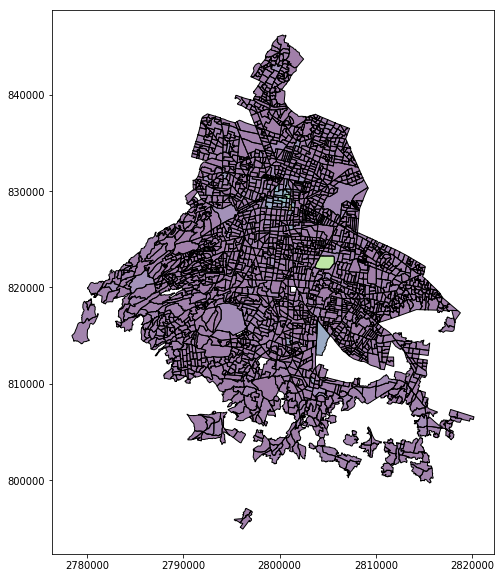

In [105]:
%matplotlib inline
usos_suelo.plot(column='clase_comercio', figsize=(20,10))

Como se ve, el mapa no muestra grandes diferencias, eso es porque por defecto, GeoPandas clasifica en intervalos iguales. Si queremos destacar las diferencias, podemos usar otros métodos de clasificación (esta opción sólo está disponible si PySal está también instalado):

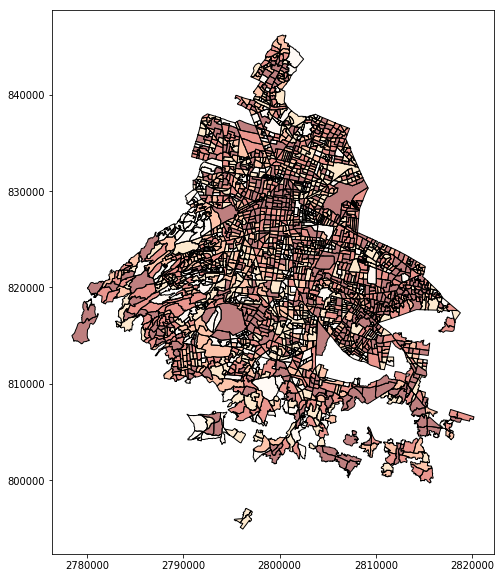

In [106]:
usos_suelo.plot(column='clase_comercio', figsize=(20,10), cmap='OrRd',scheme='quantiles')

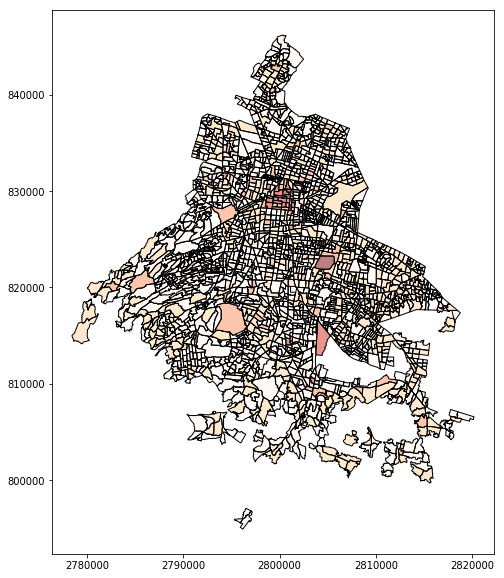

In [110]:
usos_suelo.plot(column='clase_comercio', figsize=(20,10), cmap='OrRd',scheme='fisher_jenks')